<a href="https://colab.research.google.com/github/YapingWu/GoogleColab/blob/main/genpass/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

数据集大小和数据分布

# 上传数据集

In [1]:
!unzip '/content/raw_data.zip'

Archive:  /content/raw_data.zip
  inflating: phpbb.txt               
  inflating: rockyou.txt             
  inflating: myspace.txt             


# 统计数据集大小

In [ ]:
import pandas as pd

names = ['myspace', 'phpbb', 'rockyou']
data_list = []
for name in names:
  data = pd.read_csv('/content/{}.txt'.format(name), header=None, names=['pwd'])
  data['name'] = name
  data_list.append(data)
  print('{}：{}'.format(name, data.shape))
  # print(data.head(5)

In [46]:
raw_data = pd.concat(data_list)  # 合并dataframe
print(raw_data.shape)  # (14560896, 2)

# 计算数据集中密码长度
raw_data['len'] = raw_data['pwd'].apply(lambda x: len(str(x)))
# print(raw_data.head(5))

(14560896, 2)


# 分析数据集数据分布

## 分析密码长度分布

In [ ]:
# 计算不同密码长度的密码个数
raw_data_size = raw_data.groupby(['name', 'len']).size().rename('size').reset_index()
# print(raw_data_size.head(5))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw():
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))

  x, y = {}, {}
  for index, name in enumerate(names):
    x[name] = raw_data_size.loc[raw_data_size['name'] == name, ['len']]
    y[name] = raw_data_size.loc[raw_data_size['name'] == name, ['size']]
    axs[index].plot(x[name], y[name])
    axs[index].set_title(name)
    axs[index].set_xlabel('length')
    axs[index].set_ylabel('size')

  fig.tight_layout()
  plt.show()


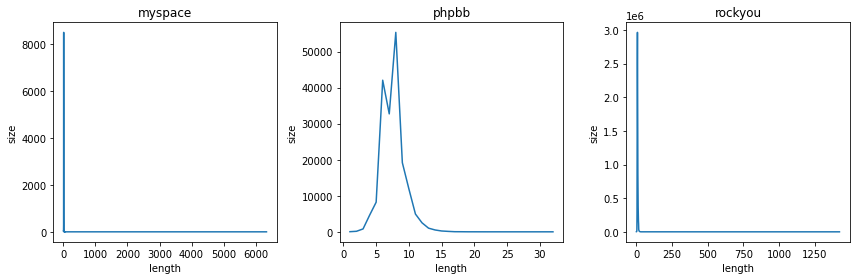

In [34]:
draw()

图中可以看出，myspace和rockyou中有很多异常值（有些密码有几千个字符）。

接下来过滤掉异常值，再分析。

In [47]:
# 过滤异常值
print('长度个数大于50的密码：%d' % len(raw_data[raw_data['len'] > 50]))  # 1183
raw_data = raw_data[raw_data['len'] <= 50]
print(raw_data.shape)  # (14559713, 3)

# 计算不同密码长度的密码个数
raw_data_size = raw_data.groupby(['name', 'len']).size().rename('size').reset_index()
# print(raw_data_size.head(5))

长度个数大于50的密码：1183
(14559713, 3)


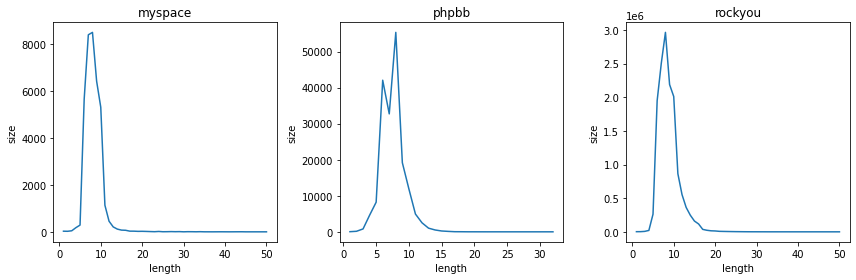

In [48]:
draw()

分析结果可看出，大部分密码长度在（5，20）区间。